In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Dataset
import pandas as pd

import statistics
from tqdm import tqdm
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [2]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Dataset
# from torch.utils.data import DataLoader
from torch_geometric.data import DataLoader

import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import sklearn
from math import sqrt
import random
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
class NYCTrafficCountDataset(Dataset):
    def __init__(self, path):
        super(NYCTrafficCountDataset, self).__init__(None)
        self.path = path
        self.time_list = os.listdir(self.path) 

        self.x_folder = r'../PreparedData/X/'

        edge_path = r'../PreparedData/adjacentMatrix.csv'
        
        self.column_list = ['SVIID',
                            'StreetWidt', 'Length',  
                            'Commercial', 'CulturalFa', 'EducationF','Government', 'HealthServ', 
                            'Miscellane', 'PublicSafe', 'Recreation', 'ReligiousI', 'Residentia', 
                            'SocialServ', 'Transporta', 'Water',
                            'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3', 'Avg_B02001',
                            'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1', 'Avg_B080_2',
                            'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001', 'Avg_B19013',
                            'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2', 'Avg_B240_3',
                            'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7', 'Avg_B240_8',
                            'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12', 'Avg_B24_13',
                            'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17', 'Avg_B24_18',
                            'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22', 'Avg_B24_23', 'Avg_B24_24']

        edge_df = pd.read_csv(edge_path)

        self.From = edge_df['From'].values
        self.To = edge_df['To'].values
        self.svi_x = pd.read_csv(r'../PreparedData/X/scene.csv').drop(columns=['Unnamed: 0']).values
        
    def len(self):
        return len(self.time_list)
    @property
    def raw_file_names(self):
        return []
#     def processed_file_names(self):
#         return ['files']
#     def download(self):
#         return 0.5
#     def indices


    
    def get(self, idx):
        
        time = self.time_list[idx]
        year = time.split('_')[0]
        
        x_name = 'Divided_' + year + '.csv'
        x_path = os.path.join(self.x_folder, x_name)
#         print(x_path)
        x_df = pd.read_csv(x_path)
        x_df = x_df[self.column_list]
        
#         x_df = (x_df - x_df.min())/(x_df.max() - x_df.min())
#         x_df['SVIID'] = sviid
        self.x = x_df.values
        self.x = np.append(self.x, self.svi_x, 1)
        
        
        
        time_path = os.path.join(self.path, time)
        df_time_series = pd.read_csv(time_path).drop('Unnamed: 0', axis=1)
        mask = df_time_series['0']!= -1
        df_time_series[mask] = df_time_series[mask] * 156.377030788485 + 106.66053597731798
        df_time_series[mask] = (df_time_series[mask] - 139) / 150
        df_time_series = df_time_series.values
        
#         x_extend_start = random.choice(range(20, 70))
        x_extend_start = 20
        
        x_extend_length = 20
        y_extend_length = 56
        
        x_extend = df_time_series[:, x_extend_start: x_extend_start + x_extend_length]
        y = df_time_series[:, x_extend_start + x_extend_length : x_extend_start + x_extend_length + y_extend_length]
#         y = np.sum(y, axis=1)
        x_raw = self.x.copy()
        x_new = np.append(x_raw, x_extend, 1)
        
        g_y = torch.tensor(y, dtype=torch.float)
        g_x = torch.tensor(x_new, dtype=torch.float)
        edge_index = torch.tensor([self.From, self.To], dtype=torch.long)
        data = Data(x=g_x, edge_index=edge_index, y=g_y)
        
        return data
        

In [4]:
test_dataset = NYCTrafficCountDataset(r'../PreparedData/Y_time/good/Weekday/Test/')
test_dataloader = DataLoader(test_dataset, 
                                 batch_size=3, 
                                 shuffle=False, 
                                 num_workers=5)

In [5]:
class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        
        self.num_layers = 1
        
        self.sep1 = nn.Linear(2, 64)
        self.sep2 = nn.Linear(13, 64)
        self.sep3 = nn.Linear(40, 128)
        self.sep3_2 = nn.Linear(365, 128)
        
        self.sep4 = nn.Linear(64, 64)
        self.sep5 = nn.Linear(64, 64)
        self.sep6 = nn.Linear(128, 128)
        self.sep7 = nn.Linear(128, 128)
        
#         

        self.conv1 = GATConv(384, 128)
#         self.norm1 = torch.nn.BatchNorm1d(128)

        self.conv2 = GATConv(128, 128)
#         self.norm2 = torch.nn.BatchNorm1d(128)

        self.conv3 = GATConv(128, 64)
#         self.norm5 = torch.nn.BatchNorm1d(64)

        self.lstm1 = nn.LSTM(20, 64, num_layers=self.num_layers)
#         self.norm6 = torch.nn.BatchNorm1d(64)
        
        
#         Fully connected layer to get the result
        self.linear1 = nn.Linear(128, 64)
        self.norm7 = torch.nn.BatchNorm1d(64)
        
        self.linear2 = nn.Linear(64, 64)
        self.norm8 = torch.nn.BatchNorm1d(8)
        
        self.linear3 = nn.Linear(64, 56)
        
    def forward(self, data):
#         print('#################################################################')
        
        x_all, edge_index = data.x, data.edge_index
        
        x_road = x_all[:, 1:3]
        x_location = x_all[:,3:16]
        x_se = x_all[:, 16:56]
        x_svi = x_all[:, 56:421]
        t = x_all[:, 421:].reshape((1, x_all.shape[0], 20))  

        x_road = self.sep1(x_road)
        x_road = F.sigmoid(x_road)
        x_road = self.sep4(x_road)
        x_road = F.relu(x_road)
        
        x_location = self.sep2(x_location)
        x_location = F.sigmoid(x_location)
        x_location = self.sep5(x_location)
        x_location = F.relu(x_location)
        
        x_se = self.sep3(x_se)
        x_se = F.sigmoid(x_se)
        x_se = self.sep6(x_se)
        x_se = F.relu(x_se)
        
#         **************SVI********************************
        x_svi = self.sep3_2(x_svi)
        x_svi = F.relu(x_svi)
        x_svi = self.sep7(x_svi)
        x_svi = F.relu(x_svi)
        
        x = torch.cat((x_road, x_location, x_se, x_svi), 1)
#         **************SVI********************************

#         **************nosvi******************************
#         x = torch.cat((x_road, x_location, x_se), 1)
    
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
#         x = F.dropout(x, training=self.training, p=0.1) 

        h0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)

        _, (hn, _) = self.lstm1(t, (h0, c0))

        t = hn[0]
        x = torch.cat((x, t), 1)
        
        x = self.linear1(x)
        x = F.relu(x)
#         x = F.dropout(x, p=0.1)
        
        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear3(x)
        
        return x

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net2().to(device)
model.load_state_dict(torch.load(r'../Weights_all/best.pt'))
model.eval()

Net2(
  (sep1): Linear(in_features=2, out_features=64, bias=True)
  (sep2): Linear(in_features=13, out_features=64, bias=True)
  (sep3): Linear(in_features=40, out_features=128, bias=True)
  (sep3_2): Linear(in_features=365, out_features=128, bias=True)
  (sep4): Linear(in_features=64, out_features=64, bias=True)
  (sep5): Linear(in_features=64, out_features=64, bias=True)
  (sep6): Linear(in_features=128, out_features=128, bias=True)
  (sep7): Linear(in_features=128, out_features=128, bias=True)
  (conv1): GATConv(384, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 64, heads=1)
  (lstm1): LSTM(20, 64)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (norm7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (norm8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features=56

In [7]:
test_sample = test_dataset[0].to(device)

In [8]:
result = model(test_sample)

In [9]:
result.shape

torch.Size([23149, 56])

In [18]:
class Net_Mid(Net2):
    def __init__(self):
        super(Net_Mid, self).__init__()
        
    def forward(self, data):
#         print('#################################################################')
        
        x_all, edge_index = data.x, data.edge_index
        
        x_road = x_all[:, 1:3]
        x_location = x_all[:,3:16]
        x_se = x_all[:, 16:56]
        x_svi = x_all[:, 56:421]
        t = x_all[:, 421:].reshape((1, x_all.shape[0], 20))  

        x_road = self.sep1(x_road)
        x_road = F.sigmoid(x_road)
        x_road = self.sep4(x_road)
        x_road = F.relu(x_road)
        
        x_location = self.sep2(x_location)
        x_location = F.sigmoid(x_location)
        x_location = self.sep5(x_location)
        x_location = F.relu(x_location)
        
        x_se = self.sep3(x_se)
        x_se = F.sigmoid(x_se)
        x_se = self.sep6(x_se)
        x_se = F.relu(x_se)
        
#         **************SVI********************************
        x_svi = self.sep3_2(x_svi)
        x_svi = F.relu(x_svi)
        x_svi = self.sep7(x_svi)
        x_svi = F.relu(x_svi)
        
        x = torch.cat((x_road, x_location, x_se, x_svi), 1)
#         **************SVI********************************

#         **************nosvi******************************
#         x = torch.cat((x_road, x_location, x_se), 1)
    
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
#         x = F.relu(x)
# # #         x = F.dropout(x, training=self.training, p=0.1) 

#         h0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)
#         c0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)

#         _, (hn, _) = self.lstm1(t, (h0, c0))

#         t = hn[0]
#         x = torch.cat((x, t), 1)
        
#         x = self.linear1(x)
#         x = F.relu(x)
# #         x = F.dropout(x, p=0.1)
        
#         x = self.linear2(x)
#         x = F.relu(x)
        
#         x = self.linear3(x)
        
        return x

In [19]:
model = Net_Mid().to(device)
model.load_state_dict(torch.load(r'../Weights_all/best.pt'))
model.eval()

Net_Mid(
  (sep1): Linear(in_features=2, out_features=64, bias=True)
  (sep2): Linear(in_features=13, out_features=64, bias=True)
  (sep3): Linear(in_features=40, out_features=128, bias=True)
  (sep3_2): Linear(in_features=365, out_features=128, bias=True)
  (sep4): Linear(in_features=64, out_features=64, bias=True)
  (sep5): Linear(in_features=64, out_features=64, bias=True)
  (sep6): Linear(in_features=128, out_features=128, bias=True)
  (sep7): Linear(in_features=128, out_features=128, bias=True)
  (conv1): GATConv(384, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 64, heads=1)
  (lstm1): LSTM(20, 64)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (norm7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (norm8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features

In [20]:
function_distance = []
flow_distance = []

for index in range(10):
    test_sample = test_dataset[index].to(device)
    result = model(test_sample)
    function = result.detach().cpu().numpy()
    flow = test_sample.y.detach().cpu().numpy()
    mask = flow[:, 0] != -1
    function = function[mask]
    flow = flow[mask]

    for i in range(function.shape[0]):
        for j in range(function.shape[0]):
            if i == j:
                continue
            else:
                DFun = np.linalg.norm(function[i] - function[j])
                DFlo = np.linalg.norm(flow[i] - flow[j])
                function_distance.append(DFun)
                flow_distance.append(DFlo)

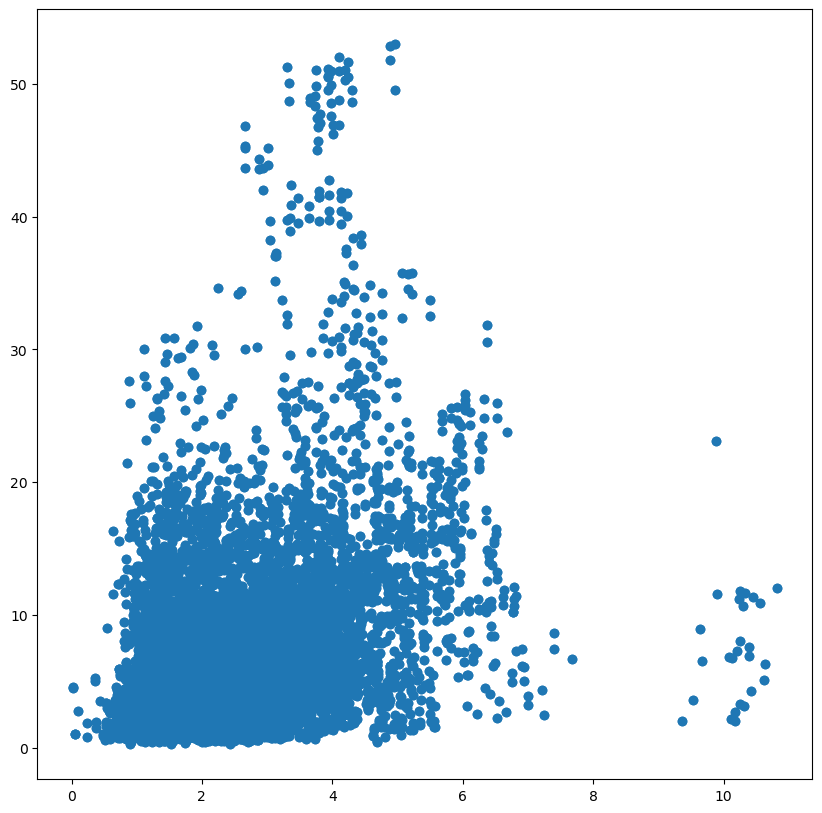

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(np.array(function_distance), np.array(flow_distance))

In [22]:
import seaborn as sns
from scipy.stats import kde

In [23]:
np.corrcoef(flow_distance, function_distance)

array([[1.        , 0.33236842],
       [0.33236842, 1.        ]])

In [24]:
y = np.array(flow_distance)
x = np.array(function_distance)
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

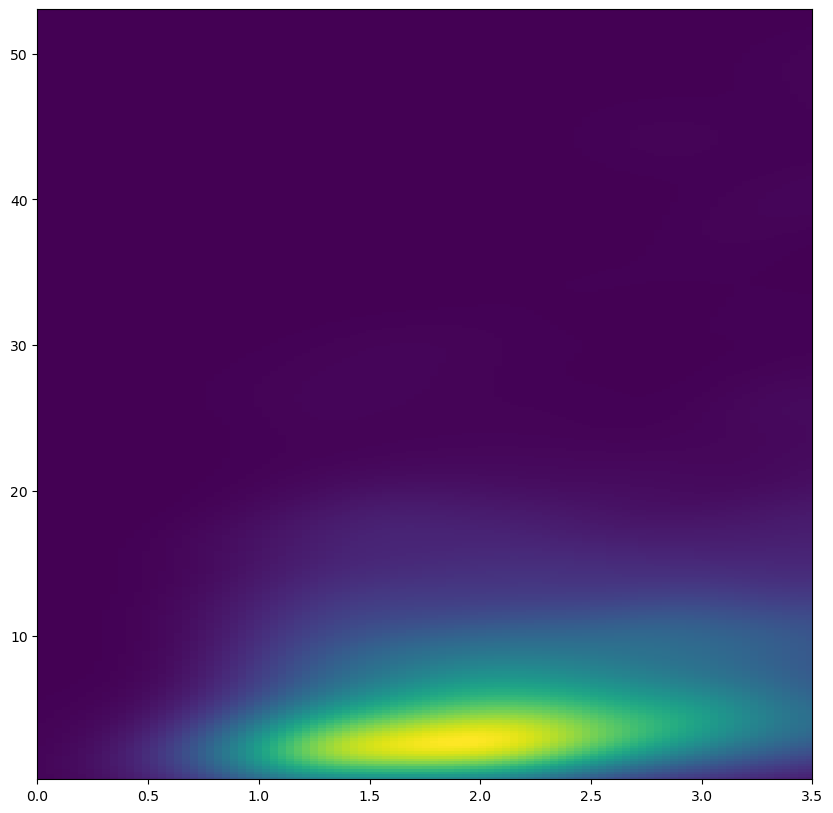

In [25]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.xlim(0, 3.5)
plt.ylim(0, 10)
# plt.show()
plt.savefig(r'../Figure/Function_SVI_SE.png')

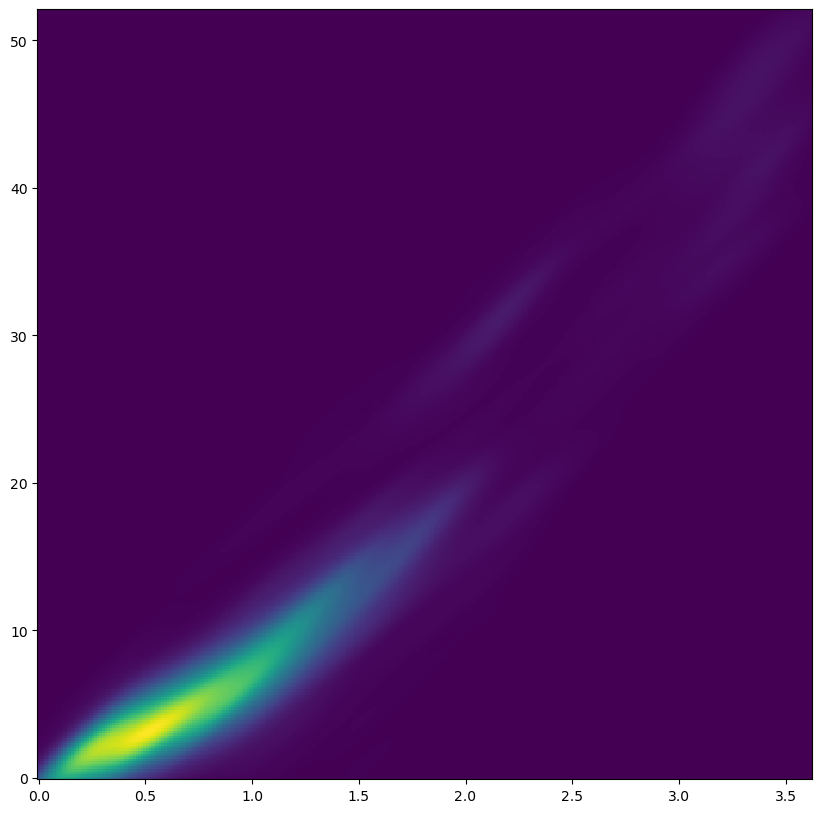

In [294]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
# plt.xlim(0, 1)
# plt.ylim(0, 10)
plt.show()

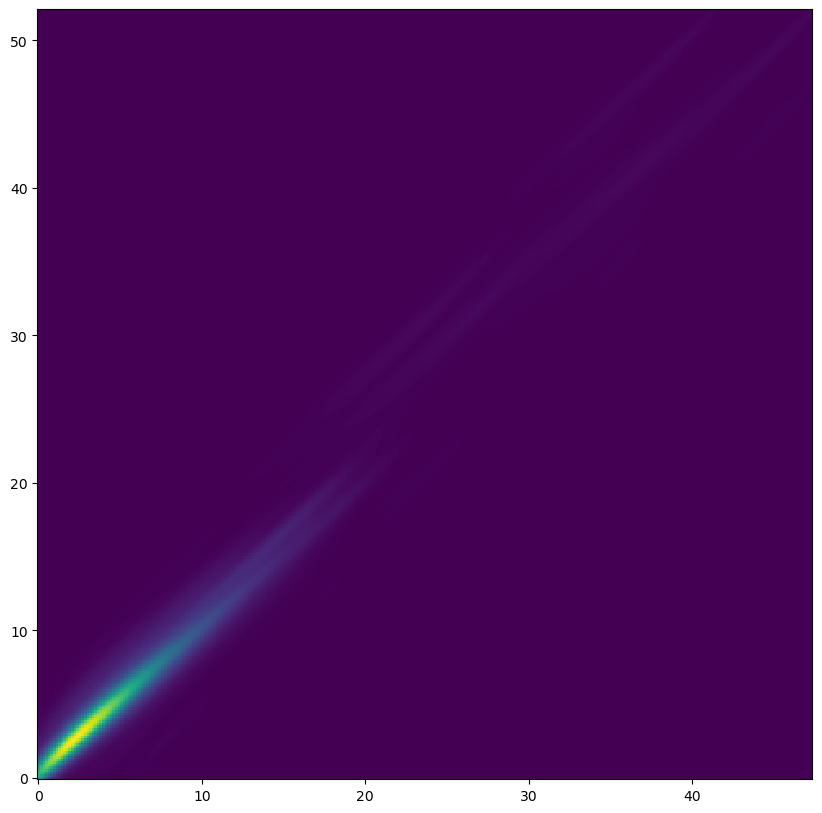

In [302]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
# plt.xlim(0, 1)
# plt.ylim(0, 10)
plt.show()

In [303]:
np.corrcoef(function_distance, flow_distance)

array([[1.        , 0.98137153],
       [0.98137153, 1.        ]])

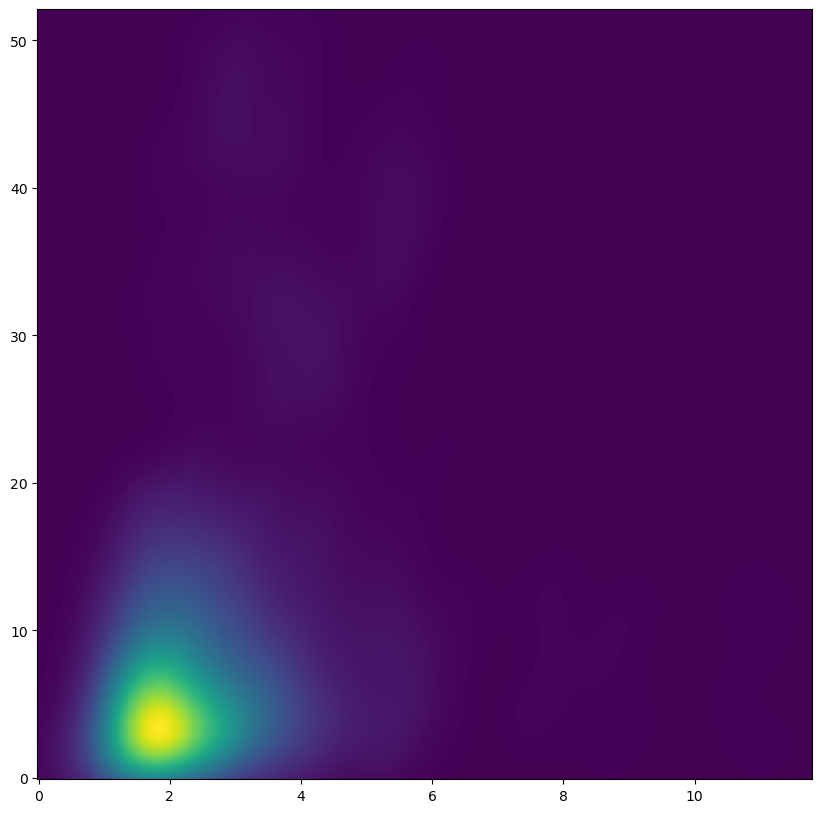

In [314]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
# plt.xlim(0, 1)
# plt.ylim(0, 10)
plt.show()

In [2]:
! conda install pyg -c pyg

^C


In [3]:
! conda install pyg -c pyg -y


Examining @/win-64::__archspec==1=x86_64:  80%|########  | 4/5 [00:19<00:06,  6.54s/it]
                                                                                       

Examining conflict for pyg python:   0%|          | 0/5 [00:00<?, ?it/s]
                                                                        

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - pyg -> python[version='>=3.10,<3.11.0a0|>=3.8,<3.9.0a0|>=3.9,<3.10.0a0|>=3.7,<3.8.0a0|>=3.6,<3.7.0a0']

Your python: python=3.11

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.





Retrieving notices: ...working... done
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed



Examining pyg:  80%|########  | 4/5 [00:00<00:00, 63.63it/s]
                                                            

Examining conflict for python pyg:   0%|          | 0/5 [00:00<?, ?it/s]
                                                                        

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - pyg -> python[version='>=3.10,<3.11.0a0|>=3.8,<3.9.0a0|>=3.9,<3.10.0a0|>=3.7,<3.8.0a0|>=3.6,<3.7.0a0']

Your python: python=3.11

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.



